In [ ]:
'''
Emma Dahl - August 2023

Rough draft of program written with the intent to provide users with the ability to extract spectra of a given type (e.g. disk-averaged, binned, etc.) from an image, put it in user-defined units (e.g. I/F or radiance), and put it into a desired format to be used as input for something (for now it'll just be nemesis). Probably a lot of fat trimming can happen

This program utilizes an early version of pylanetary (https://github.com/emolter/pylanetary), specifically
the navigation.ModelBody module. Be sure to install it first.

Currently in notebook format but should not be eventually. Added package to pylanetary-test enviornment: https://medium.com/@nrk25693/how-to-add-your-conda-environment-to-your-jupyter-notebook-in-just-4-steps-abeab8b8d084 so i could run this notebook in the right conda environment. Later on will need to make sure pylanetary is available and/or you're in the right conda environment to run it

guidelines on docstrings: https://sphinxcontrib-napoleon.readthedocs.io/en/latest/example_numpy.html
examples also in pylanetary/navigation/core.py

------------
Notes:

Inputs:
type of spectra to extract: zonal mean, binned, disk-averaged, Zonal mean but binned by emission angle in each latitude circle, single lat/lon point

If binned, how many bins? max/min size? defined by number of bins vs. size of bins?

Format: could the user specify the format they'd like the spectra to be in? e.g. Nemesis, or something different?

does nav take generic terms for header keywords? is there an option to add specific keywords since not all headers are written the same? If not, should be a functionality. 

From Ned: for spatial averaging of a spectrum, you may want to make use of utils.convolve_with_beam, which allows convolution of a 2-D field with a 2-D Gaussian or arbitrary PSF. We also already have a function for computing I/F from erg s-1 cm-2 um-1 (https://github.com/emolter/pylanetary/blob/main/pylanetary/utils/core.py#L294)

------------

To-do list:
-Make sure everything's in the right format for pylanetary
-Make sure docstrings are right
-Maybe BeamRays can be included here eventually for radio-specific observations
-Currently in notebook format but should not be eventually. Added package to pylanetary-test enviornment: https://medium.com/@nrk25693/how-to-add-your-conda-environment-to-your-jupyter-notebook-in-just-4-steps-abeab8b8d084 so i could run this notebook in the right conda environment. Later on will need to make sure pylanetary is available and/or you're in the right conda environment to run it
-Should probably make some of it subroutines? e.g. might be useful to calculate JD quickly from UT date and time elsewhere

'''

In [1]:
# Is there anything superfluous here?

from pylanetary.navigation import *
from pylanetary.utils import Body
#from pylanetary.utils import I_over_F
from pylanetary.utils import *
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.units as u

from astroquery.jplhorizons import Horizons
from datetime import datetime

In [176]:
def spextraction(filename, ut_date='DATE_OBS', ut_time='TIME_OBS', target='OBJECT', location_code='568', pixelscale=0.115696, plot_maps=0):
    '''
    docstring goes here
    Anything flagged with !! is something hard-coded for the IRTF which should probably be changed for future generic versions of this code. Or else be made optional arguments.
    
    input
    ---------
    filename - string, path+name of fits file to map.
    
    optional keyword arguments; defaults are those used by the IRTF
    ut_date - the UT date of the observation
    ut_time - the average UT time of the observation
    target - planet being observed. so far just the gas giants are included. Adding more will require including more of the planets and their corresponding Horizons codes in the planets variable. Can probably just be a string of the planet's name.
    
    location_code - string, horizons code of observing location. default = 568, Mauna Kea
    pixelscale - pixel scale of observatory in "/pix. Default is guide dog on IRTF SpeX
    
    plot_maps - on/off switch for plotting lat/long/mu maps, as a check. 1 = maps will be plotted, 0 = maps will not be plotted. Default is 0.
    
    To add:
    cx, cy - strings, planet center in x and y keyword values. currently hard-coded as keywords used by IRTF
    
    
    output
    -----------
    ellipsoid - pylanetary ellipsoid object
    pixscale_km - pixel scale in km/pix as calculated here
    '''
    
    # tuples of planets and their Horizons codes. Only gas giants for now, can add terrestrial planets. Horizons code, name, equatorial radius (km), polar radius (km). would be nice to be able to pull radii from horizons eventually
    planets = ('599','Jupiter',71492,66854),('699','Saturn',60268,54364),('799','Uranus',25559,24973),('899','Neptune',24766,24342)

    
    # first, use ModelEllipsoid to generate maps for a given image. Need to get sub-obs lon and lat, pixel scale, north polar angle, equatorial radius and polar radius from Horizons by pulling info from header.

    # import image
    im = fits.open(filename)
    header = im[0].header
    data = im[0].data
    
    
    # based on UT time/date and location of observations, query Horizons for viewing geom info
    UT_date = header[ut_date] 
    UT_time = header[ut_time]
    target = 'Jupiter'# header[target] # observed planet. maybe just put this as planet as optional input
    
    # Account for fractional seconds in UT_time if it exists. datetime does not like fractional seconds.
    if '.' in UT_time:
        nofrag, frag = UT_time.split('.')
        UT_time = nofrag    
    
    # Query horizons. !! The date/time format for UT_date and UT_time as used in date_obj are specific to the format used by the IRTF.
    for k in planets: # find planet code. save r_eq and r_pol
        if k[1] == target: # assumes target string is exactly correct. might be an issue if there are additional spaces
            id_number = k[0]; planet_label = k[1]; req = k[2]; rpol = k[3]
    
    # calculate julian date
    date_obj = datetime.strptime(UT_date+' '+UT_time, '%Y-%m-%d %H:%M:%S') # define datetime object based on UT date and time. Might have issue bc seconds are fractional
    date_only_obj = datetime.strptime(UT_date, '%Y-%m-%d')
    h = int(date_obj.strftime("%H"))
    m = int(date_obj.strftime("%M"))
    s = int(date_obj.strftime("%S"))
    dt = timedelta(hours=h, minutes=m, seconds=s)
    secs_per_day = 24*60*60    # hours * mins * secs
    jd_time_fraction = dt.total_seconds()/secs_per_day # fraction of day time, to add to date
    
    jd = date_only_obj.toordinal() + 1721424.5 + jd_time_fraction # based on https://stackoverflow.com/questions/13943062/extract-day-of-year-and-julian-day-from-a-string-date
    
    # define horizons query
    obj = Horizons(id=id_number, location=location_code, epochs=jd) 
    
    # put ephimerides into a table
    table = obj.ephemerides()
    distance = table['delta'][0]*1.496E8 # in AU, convert to km
    
    # define values needed for ModelEllopsoid
    ob_lon = table['PDObsLon'][0] #degrees
    ob_lat = table['PDObsLat'][0] #degrees
    pixscale_km = np.arctan(pixelscale*(1/206265))*distance
    np_ang = table['NPole_ang'][0] #degrees
    
    # Make an ellipsoid of the planet to map
    ellipsoid = ModelEllipsoid(ob_lon, ob_lat, pixscale_km, np_ang, req, rpol)
    
    #return ellipsoid, pixscale_km # original return for program
    
    
    
    # section that makes projpolar solar input. could be a seperate subroutine? - - - - - - 
    
    # !! hard coded planet center value keywords for IRTF
    cx = im[0].header['cx']; cy = im[0].header['cy']
    x1 = im[0].header['naxis1']/2; y1 = im[0].header['naxis2']/2

    x_offset = int(cx-x1); y_offset = int(cy-y1) # make ints to make life easier. 

    obs_time = UT_date + ' ' + UT_time
    #print(obs_time)

    # something like this
    jup = Body(target, epoch=obs_time, location=location_code) 
    model = ModelBody(jup, pixelscale, shape=(header['NAXIS1']+2*x_offset,header['NAXIS2']+2*y_offset)) # why do I need to multiply this by 2
    nav = Nav(data, jup, pixelscale)


    nav.xy_shift_model(x_offset, y_offset)

    if plot_maps == 1: # plot lat, long, emission, and data. check to make sure things are alligning properly. 
        fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize = (15, 6))

        im0 = ax0.imshow(nav.lon_w, origin = 'lower')
        ax0.set_title('West Longitudes')
        im1 = ax1.imshow(nav.lat_g, origin = 'lower')
        ax1.set_title('Planetographic Latitudes')
        im2 = ax2.imshow(nav.mu, origin = 'lower')
        ax2.set_title('Emission Angles')
        im3 = ax3.imshow(im[0].data, origin = 'lower')
        ax3.set_title('data')


        ax0.set_ylabel('Distance (pix)')
        ax1.set_yticks([])
        ax2.set_yticks([])
        ax3.set_yticks([])

        for ax in [ax0, ax1, ax2, ax3]:
            ax.set_xlabel('Distance (pix)')
            ax.set_aspect('equal')

        plt.show()
    
    # - - - - - - - -

    # then use those as input to projposolar

In [ ]:
def projposolar_input_maker():
    
    

In [45]:
ellipsoid, pixscale_km = spextraction('/Users/emmadahl/Desktop/spextraction/test_data/jupiter/jcf01170125.gz.fits')

In [46]:
# ?? does ellipsoid assume that the image top corresponds to celestial north? 

(313, 313)


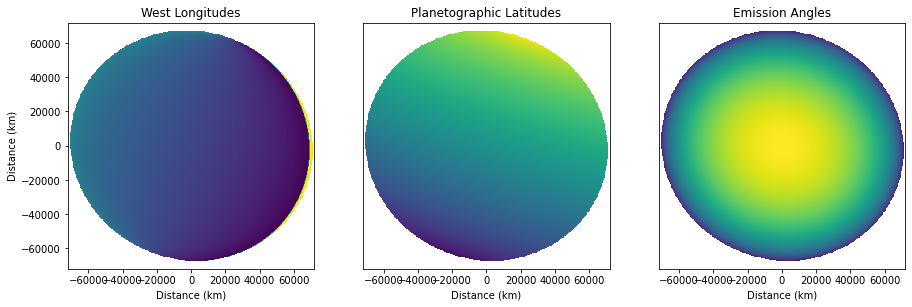

In [47]:

shape = ellipsoid.lon_w.shape
print(shape)

extent = (-pixscale_km*shape[0]/2, pixscale_km*shape[0]/2, -pixscale_km*shape[1]/2, pixscale_km*shape[1]/2)
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (15, 6))

im0 = ax0.imshow(ellipsoid.lon_w, origin = 'lower', extent=extent)
ax0.set_title('West Longitudes')

im1 = ax1.imshow(ellipsoid.lat_g, origin = 'lower', extent=extent)
ax1.set_title('Planetographic Latitudes')

im2 = ax2.imshow(ellipsoid.mu, origin = 'lower', extent=extent)
ax2.set_title('Emission Angles')

ax0.set_ylabel('Distance (km)')
ax1.set_yticks([])
ax2.set_yticks([])

for ax in [ax0, ax1, ax2]:
    ax.set_xlabel('Distance (km)')

plt.show()
plt.close()

In [ ]:
# co-locate images. pylanetary should be able to do this but having some issues, so doing it manually

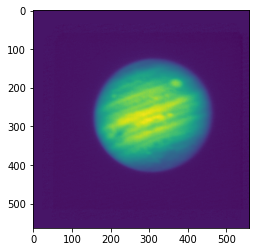

In [130]:
plt.imshow(hdul[0].data)
plt.show()

In [121]:
# find offsets for co=locating maps
hdul = fits.open('/Users/emmadahl/Desktop/spextraction/test_data/jupiter/jcf01170125.gz.fits') #urh60.fits
cx = hdul[0].header['cx']; cy = hdul[0].header['cy']
x1 = hdul[0].header['naxis1']/2; y1 = hdul[0].header['naxis2']/2

x_offset = int(cx-x1); y_offset = int(cy-y1) # make ints to make life easier. 



# expand original maps by these values. then make the offset maps the size of the original image; offset map should be centered over planet

(27, -10)

(313, 313)


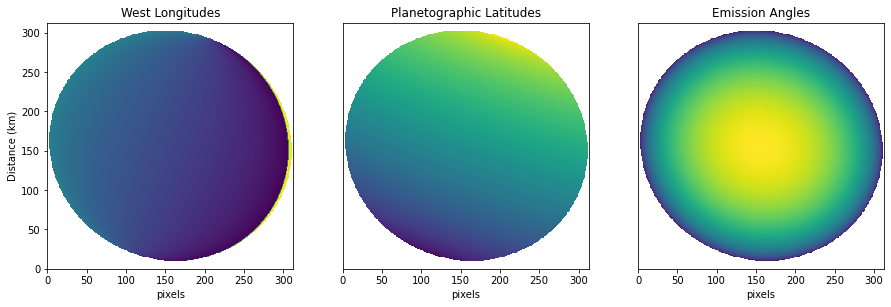

In [129]:
shape = ellipsoid.lon_w.shape
print(shape)

extent = (0, shape[0], 0, shape[1])
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (15, 6))

im0 = ax0.imshow(ellipsoid.lon_w, origin = 'lower', extent=extent)
ax0.set_title('West Longitudes')

im1 = ax1.imshow(ellipsoid.lat_g, origin = 'lower', extent=extent)
ax1.set_title('Planetographic Latitudes')

im2 = ax2.imshow(ellipsoid.mu, origin = 'lower', extent=extent)
ax2.set_title('Emission Angles')

ax0.set_ylabel('Distance (km)')
ax1.set_yticks([])
ax2.set_yticks([])

for ax in [ax0, ax1, ax2]:
    ax.set_xlabel('pixels')

plt.show()
plt.close()

In [127]:
ellipsoid.mu

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [167]:
pixscale_arcsec = 0.115696 #arcsec, IRTF guidedog

header = hdul[0].header
data = hdul[0].data
obs_time = header['DATE_OBS'] + ' ' + header['TIME_PC'][:-4]
print(obs_time)

# something like this
jup = Body('Jupiter', epoch=obs_time, location='568') 
model = ModelBody(jup, pixscale_arcsec, shape=(header['NAXIS1']+2*x_offset,header['NAXIS2']+2*y_offset))
nav = Nav(data, jup, pixscale_arcsec)

2023-06-24 16:09:19.15


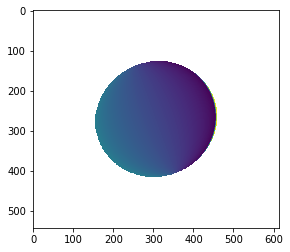

In [160]:
plt.imshow(model.lon_w)


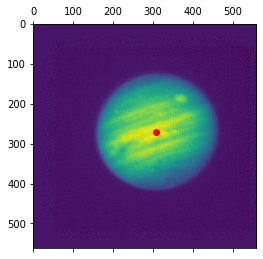

In [158]:
plt.matshow(data)
plt.plot(307.5,271.3,'ro')
plt.show()

307.5


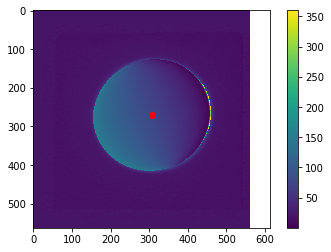

In [159]:
print(hdul[0].header['CX'])

plt.imshow(data)
plt.imshow(model.lon_w)
plt.plot(307.5,271.3,'ro')
plt.colorbar()

In [ ]:
# once images are co-located, use projposolar routines to make maps of values nemesis needs.

2023-06-24 16:09:19.15


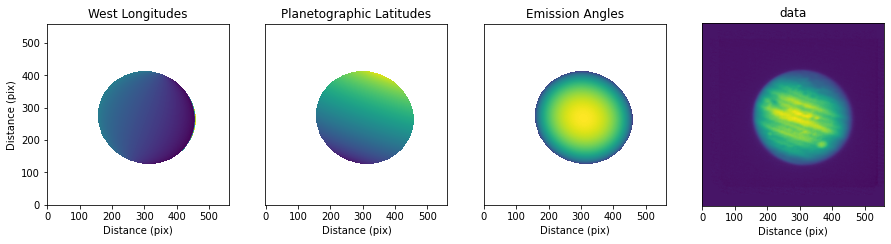

In [175]:
hdul = fits.open('/Users/emmadahl/Desktop/spextraction/test_data/jupiter/jcf01170125.gz.fits') #urh60.fits
cx = hdul[0].header['cx']; cy = hdul[0].header['cy']
x1 = hdul[0].header['naxis1']/2; y1 = hdul[0].header['naxis2']/2

x_offset = int(cx-x1); y_offset = int(cy-y1) # make ints to make life easier. 

pixscale_arcsec = 0.115696 #arcsec, IRTF guidedog

header = hdul[0].header
data = hdul[0].data
obs_time = header['DATE_OBS'] + ' ' + header['TIME_PC'][:-4]
print(obs_time)

# something like this
jup = Body('Jupiter', epoch=obs_time, location='568') 
model = ModelBody(jup, pixscale_arcsec, shape=(header['NAXIS1']+2*x_offset,header['NAXIS2']+2*y_offset))
nav = Nav(data, jup, pixscale_arcsec)


nav.xy_shift_model(x_offset, y_offset)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize = (15, 6))

im0 = ax0.imshow(nav.lon_w, origin = 'lower')
ax0.set_title('West Longitudes')
im1 = ax1.imshow(nav.lat_g, origin = 'lower')
ax1.set_title('Planetographic Latitudes')
im2 = ax2.imshow(nav.mu, origin = 'lower')
ax2.set_title('Emission Angles')
im3 = ax3.imshow(hdul[0].data, origin = 'lower')
ax3.set_title('data')


ax0.set_ylabel('Distance (pix)')
ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])

for ax in [ax0, ax1, ax2, ax3]:
    ax.set_xlabel('Distance (pix)')
    ax.set_aspect('equal')

plt.show()

# then use those as input to projposolar

In [ ]:
# add spectral extraction code here

In [86]:
np.shape(model.lat_g)
#np.shape(data)

(313, 313)

In [161]:

# !! Need to figure out what these are I guess

flux = 2700 # surface brightness in whatever units are in the fits file
a = 0.1 # exponential limb-darkening law exponent
fwhm_keck = 0.5 # approximate FWHM of the point-spread function in arcsec

ldmodel = ellipsoid.ldmodel(flux, a, beam=fwhm_keck, law='exp')

## save ldmodel as numpy file for testing suite - delete later
#np.save('/Users/emolter/Python/pylanetary/pylanetary/navigation/tests/data/ldmodel.npy', ldmodel)

# center the lat, lon, and mu grids. 
# note it is not necessary to make the ldmodel separately (as shown above) in order to run centering
# err should be the RMS noise of the image
rms_noise = np.std(data[500:562,500:560]) * 10 #for some reason, error returns zero if true RMS is used
# wonder if this should truly be per-pixel error, or per-beam error
dx, dy, dxerr, dyerr = nav.colocate(mode='disk', tb = flux, a = a, beam = fwhm_keck, err=rms_noise)

print('suggested x,y shift is ', dx, dy)
print('x,y uncertainty is ', dxerr, dyerr)

# we could also use an edge-detection algorithm. this is useful if 
# the planet disk is faint and the clouds are bright, e.g., for Neptune in K-band
dx_canny, dy_canny, _, _ = nav.colocate(mode='canny', tb = flux, a = a, beam = fwhm_keck, low_thresh=1e-5, high_thresh=0.01, sigma=5)

print('Canny x,y shift is', dx_canny, dy_canny)

nav.xy_shift_model(dx, dy)
## note: alternatively, we could center the data
# nav.xy_shift_data(-dx, -dy)


#extent = (-pixscale_km*shape[0]/2, pixscale_km*shape[0]/2, -pixscale_km*shape[1]/2, pixscale_km*shape[1]/2)
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (15, 6))

im0 = ax0.imshow(nav.lon_w, origin = 'lower')
ax0.set_title('West Longitudes')
im1 = ax1.imshow(nav.lat_g, origin = 'lower')
ax1.set_title('Planetographic Latitudes')
im2 = ax2.imshow(nav.mu, origin = 'lower')
ax2.set_title('Emission Angles')

ax0.set_ylabel('Distance (pix)')
ax1.set_yticks([])
ax2.set_yticks([])

for ax in [ax0, ax1, ax2]:
    ax.set_xlabel('Distance (pix)')
    ax.set_aspect('equal')

plt.show()

ValueError: Images must have same shape.